# SDO/AIA and Solar Orbiter/EUI alignment tutorial

In this tutorial, we will

- Retrive HRI EUV 174 EUI data and AIA data using [Fido](https://docs.sunpy.org/en/stable/generated/api/sunpy.net.Fido.html#sunpy.net.Fido)
- Correct for 'jitter' in EUI images
- align aia/eui images in time (account for timing delay)
- use wcs to align in space
- for small scale, may need to apply additional correction

----

Before jumping in, we first need to import the necessary packages. The cell should have no issues running if your conda environment is setup correctly or if you're running this notebook externally via Binder.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import astropy
from astropy.visualization import ImageNormalize, SqrtStretch, PowerStretch
from astropy.io import fits

import sunpy
import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a

import astropy.units as u
from astropy.coordinates import SkyCoord

import skimage
import scipy

from tqdm import tqdm

# import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

# big plots!
plt.rcParams["figure.figsize"] = (10, 10)

---

First let's retrieve the data using SunPy's Fido! We'll be working with a short HRIEUV time series on March 5th 2022.


In [2]:
# EUI
instrument = a.Instrument('EUI')

start_time = '2022-03-05 15:20:00'
end_time = '2022-03-05 15:20:30'

time = a.Time(start_time, end_time)

level = a.Level(2)

product = a.soar.Product('eui-hrieuv174-image')

eui_result = Fido.search(instrument & time & level & product)

# print out the files found
print(eui_result)

Results from 1 Provider:

6 Results from the SOARClient:

Instrument     Data product    Level ... Detector Wavelength
                                     ...                    
---------- ------------------- ----- ... -------- ----------
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0
       EUI eui-hrieuv174-image    L2 ...  HRI_EUV      174.0




Let's download the EUI files we queried for

In [3]:
# fetch the data files
eui_files = Fido.fetch(eui_result)

# read the data files in as a sequence of SunPy maps
eui_seq = sunpy.map.Map(eui_files, sequence=True)

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

Now that we have our data as Sunpy maps, we can easily make a movie

2025-02-20 11:59:21 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 11:59:21 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


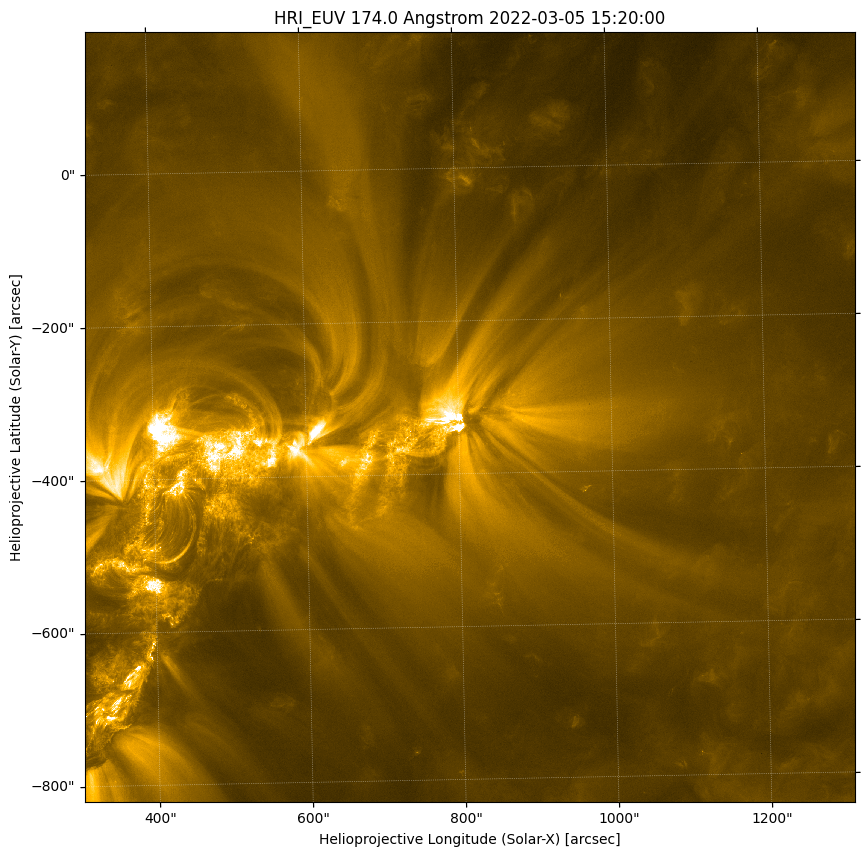

In [4]:
for each_map in eui_seq:

    # normalize each map the same way
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=10000, stretch=SqrtStretch())
    
plt.figure()
ani = eui_seq.plot()

# make animation and save a gif !
ani.save('gifs/first_eui_animation.gif')

Now we have a movie of the EUI data we retrieved!
![SegmentLocal](gifs/first_eui_animation.gif "segment")

Let's zoom in!

In [5]:
submaps = []

for each_map in eui_seq:

    # bl = [50,500] * u.pixel
    # tr = [450,900] * u.pixel

    bl = [300,800] * u.pixel
    tr = [800,1300] * u.pixel

    ## YOU CAN ALSO SPECIFY THE COORDINATES IN ARCSEC 
    # bl = SkyCoord(350*u.arcsec, -550*u.arcsec, frame=each_map.coordinate_frame)  # bottom left coordinate
    # tr = SkyCoord(500*u.arcsec, -400*u.arcsec, frame=each_map.coordinate_frame)  # top right coordinate

    submap = each_map.submap(bl, top_right=tr)
    submaps.append(submap)

eui_seq_submaps = sunpy.map.Map(submaps, sequence=True)

2025-02-20 11:59:23 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 11:59:23 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


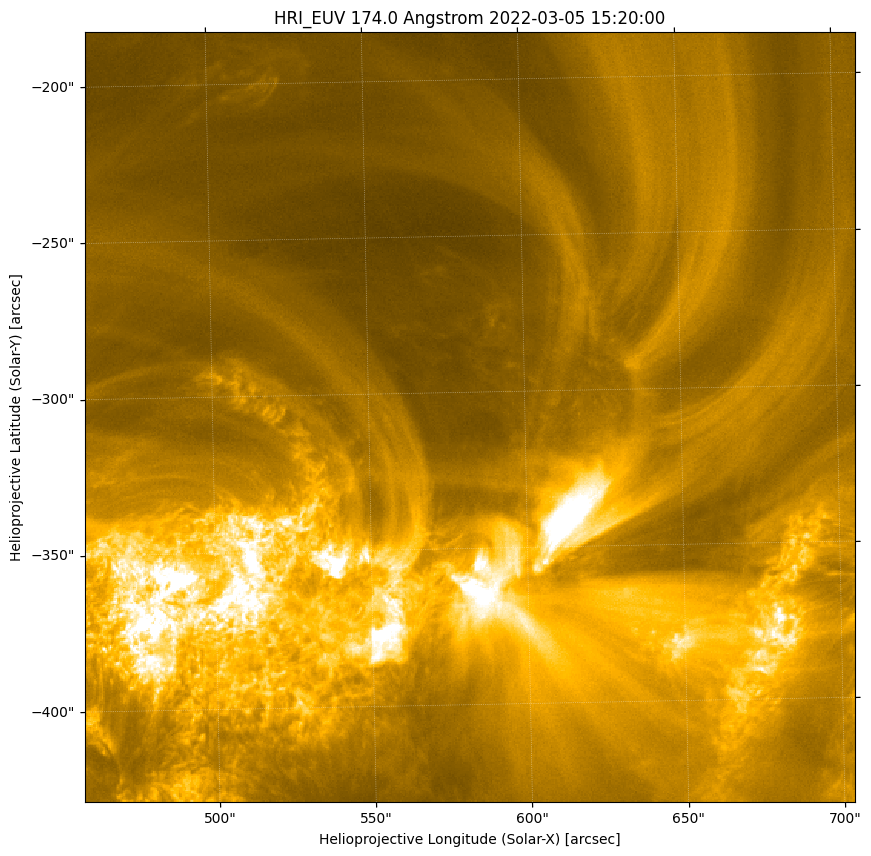

In [6]:
ani = eui_seq_submaps.plot()

ani.save('gifs/submap_eui_animation.gif')

![SegmentLocal](gifs/submap_eui_animation.gif "segment")

Hmmm looks like there's some jitter...

Let's do a few things the try and correct this. Starting with correcting for differential rotation. This won't have a huge affect on the time series we're working with (since it's so short) but plays a big role for other observations.

In [7]:
def correct_diff_rot(one_map, ref):
    """
    https://docs.sunpy.org/en/stable/generated/gallery/differential_rotation/reprojected_map.html

    Parameters
    ----------
    one_map: SunPy map object
        the map to derotate
    
    ref: SunPy map object
        the map to use as a reference for derotating

    Returns
    -------
    out_warp: SunPy map object
        `one_map` rotated to `ref`
    """
    in_time = one_map.date
    out_time = ref.date

    out_frame = sunpy.coordinates.Helioprojective(observer='earth',
                                                  obstime=out_time,
                                                  rsun=one_map.coordinate_frame.rsun)

    out_center = ref.center
    header = sunpy.map.make_fitswcs_header(one_map.data.shape,
                                           out_center,
                                           scale=u.Quantity(one_map.scale))
    out_wcs = astropy.wcs.WCS(header)

    with sunpy.coordinates.propagate_with_solar_surface():
        out_warp = one_map.reproject_to(out_wcs)

    return out_warp

In [8]:
eui_rotated_maps = []

for one_map in tqdm(eui_seq_submaps[0:]): # skip first one that will be our reference

    new_map = correct_diff_rot(one_map, eui_seq_submaps[0])

    eui_rotated_maps.append(new_map)

eui_rotated_seq = sunpy.map.Map(eui_rotated_maps, sequence=True)

2025-02-20 11:59:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode?it/s]
2025-02-20 11:59:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode7it/s]
2025-02-20 11:59:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode3it/s]
2025-02-20 11:59:25 - reproject.common - INFO: Calling _reproject_full in non-dask mode2it/s]
2025-02-20 11:59:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode4it/s]
2025-02-20 11:59:26 - reproject.common - INFO: Calling _reproject_full in non-dask mode9it/s]
100%|██████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.25it/s]


In [9]:
eui_rotated_seq[3].reference_date, eui_seq[3].date

(<Time object: scale='utc' format='isot' value=2022-03-05T15:20:01.647>,
 <Time object: scale='utc' format='isot' value=2022-03-05T15:20:15.247>)

A note about this technique: it does not preserve the original time information in the headers. We'll have to access the original sequence of SunPy maps for the accurate times.

---

Still some jitter... this is from the instrument pointing and can't be corrected with techniques dervived from FITS file keywords. We'll have to apply a manual correction. Here we'll use cross correlation. I found that this works best on a small and relatively stable region.

(another method walked through here: https://github.com/SolarOrbiterWorkshop/solo8_tutorials/blob/main/EUI_tutorial/3_alignment_b.ipynb)

Let's try cross correlation on a small FOV:

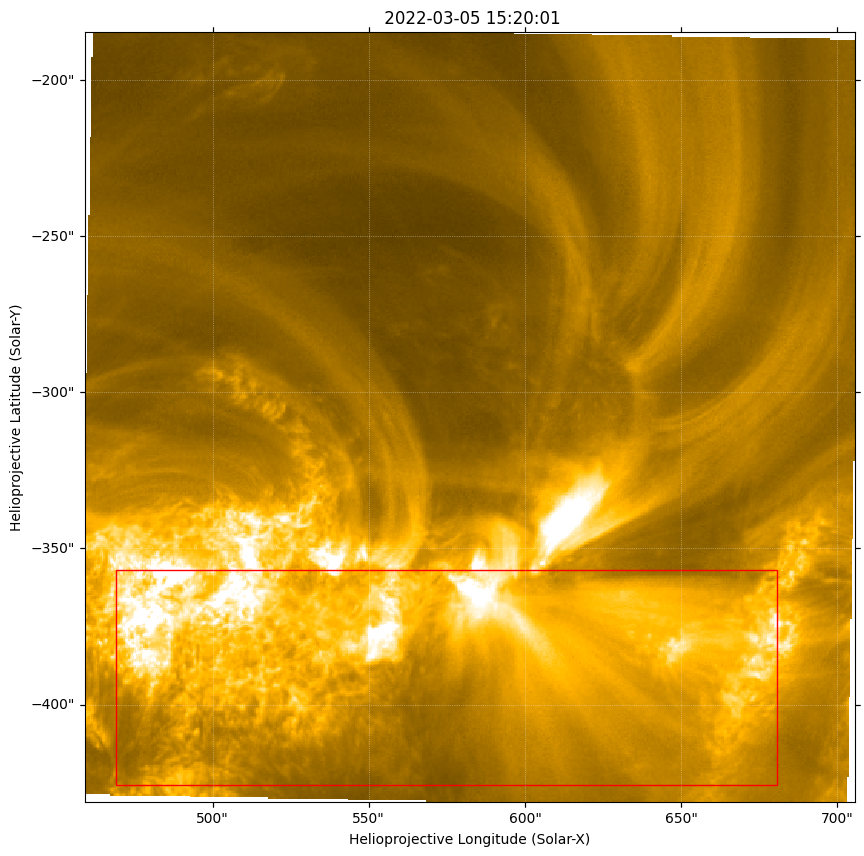

In [10]:
first_map = eui_rotated_seq[0] # one example eui image

fig = plt.figure()
ax = fig.add_subplot(projection=first_map)
first_map.plot(axes=ax)

# box_xs = [20, 380]
# box_ys = [10, 120]

box_xs = [20, 450]
box_ys = [10, 150]

bottom_left = first_map.wcs.pixel_to_world(box_xs[0] * u.pixel, box_ys[0] * u.pixel)
top_right = first_map.wcs.pixel_to_world(box_xs[1] * u.pixel, box_ys[1] * u.pixel)
first_map.draw_quadrangle(bottom_left, axes=ax, top_right=top_right, edgecolor="red")

In [11]:
shifts = []

for i in range(len(eui_rotated_seq)): # on the derotated sequence!

    if i == 0: # using first image as reference, no shift
        shift = [0, 0]
        
    else:
        img1 = eui_rotated_seq[i-1].data[box_ys[0]:box_ys[1], box_xs[0]:box_xs[1]]
        img2 = eui_rotated_seq[i].data[box_ys[0]:box_ys[1], box_xs[0]:box_xs[1]]
    
        # sub pixel cross correlation
        shift, error, phasediff = skimage.registration.phase_cross_correlation(img1, # reference image
                                                                               img2, # moving image
                                                                               upsample_factor=100)
    shifts.append(shift)

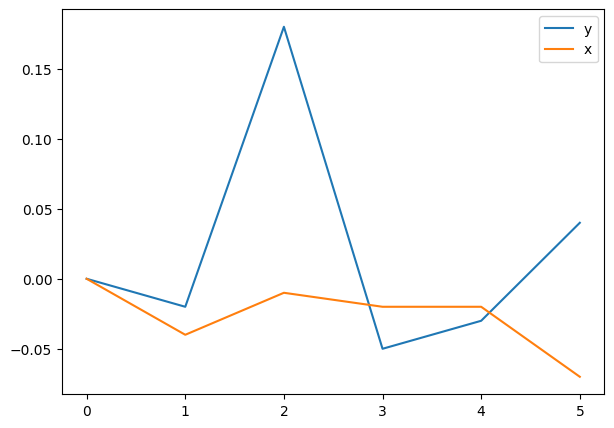

In [12]:
plt.figure(figsize=(7, 5))

plt.plot(shifts, label=['y','x'])
plt.legend()

In [13]:
# SMOOTH THE SHIFTS FROM CROSS CORRELATING USING NP.CONVOLVE
def smooth_shifts(shifts, kernel_size=2):
    """# https://danielmuellerkomorowska.com/2020/06/02/smoothing-data-by-rolling-average-with-numpy/
    """
    y = []; x = []
    for i in shifts:
        y.append(i[0]); x.append(i[1])

    kernel = np.ones(kernel_size) / kernel_size
    y_convolved = np.convolve(y, kernel, mode='same')
    x_convolved = np.convolve(x, kernel, mode='same')

    y_convolved[:kernel_size] = y[:kernel_size]
    y_convolved[-kernel_size:] = y[-kernel_size:]
    x_convolved[:kernel_size] = x[:kernel_size]
    x_convolved[-kernel_size:] = x[-kernel_size:]

    shifts_smoothed = []

    for i in range(len(y_convolved)):
        shifts_smoothed.append(np.array([y_convolved[i], x_convolved[i]]))

    return shifts_smoothed

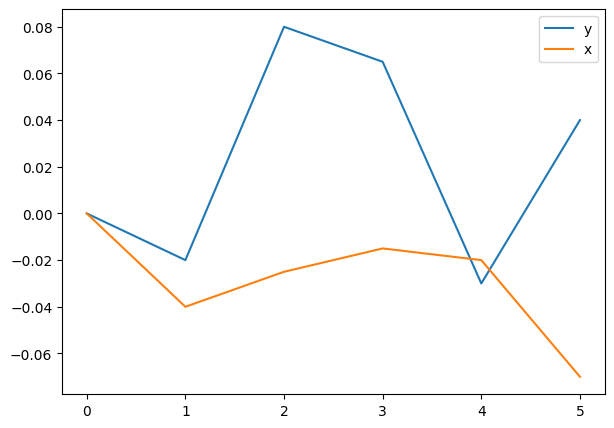

In [14]:
shifts_smoothed = smooth_shifts(shifts)

plt.figure(figsize=(7, 5))

plt.plot(shifts_smoothed, label=['y','x'])
plt.legend()

In [15]:
y = []; x = []
for i in shifts_smoothed:
    y.append(i[0]); x.append(i[1])

# sum the shifts
x_summed = [np.sum(x[:i]) for i in range(len(x))]
y_summed = [np.sum(y[:i]) for i in range(len(y))]

shifts_summed = []
for i in range(len(y_summed)):
        shifts_summed.append(np.array([y_summed[i], x_summed[i]]))

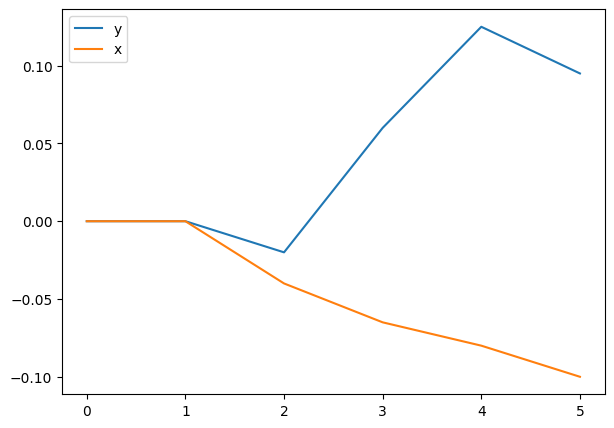

In [16]:
plt.figure(figsize=(7, 5))

plt.plot(shifts_summed, label=['y','x'])
plt.legend()

Now that we have unique shift value for each image in X and Y. Let's apply them:

In [17]:
def apply_shift(img, shift, cmap, norm):
    """Perform sub-pixel image shift using fast fourier transforms
    (using scipy.ndimage's fourier_shift)
    
    Parameters
    ----------
    img: SunPy Map
        map to shift
        
    shift: list, size 2 (output of cross_correlate)
        shift[0] is shift to apply in y;
        shift[1] is shift to apply in x

    Returns
    -------
    shift_map: SunPy Map
        "img" shifted using values specified in "shift".
        Shifted bounds filled in with zeroes.
    """

    data = img.data
    
    data[np.isnan(data)] = 0

    shift_img = scipy.ndimage.fourier_shift(np.fft.fftn(data), shift)
    shift_img = np.fft.ifftn(shift_img).real # only keep real part

    # fill in parts of the shifted array with zeroes -- round up to integer
    y, x = shift
    if y > 0:
        shift_img[:int(y+1), :] = 0
    else:
        shift_img[int(y-1):, :] = 0

    if x > 0:
        shift_img[:, :int(x+1)] = 0
    else:
        shift_img[:, int(x-1):] = 0

    # recreate SunPy map
    shift_map = sunpy.map.Map((shift_img, img.meta))

    # color and normalize the same as before
    shift_map.plot_settings['cmap'] = cmap
    shift_map.plot_settings['norm'] = norm

    return shift_map

In [18]:
shifted_maps = []

for i, one_map in enumerate(eui_rotated_seq):

    shifted_map = apply_shift(one_map, 
                              shifts_summed[i], 
                              cmap='solar orbiterhri_euv174', 
                              norm=ImageNormalize(vmin=0, vmax=10000, stretch=SqrtStretch()))
    
    shifted_maps.append(shifted_map)

eui_stable_seq = sunpy.map.Map(shifted_maps, sequence=True)

Let's play the zoom in movie again!

2025-02-20 11:59:27 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 11:59:27 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


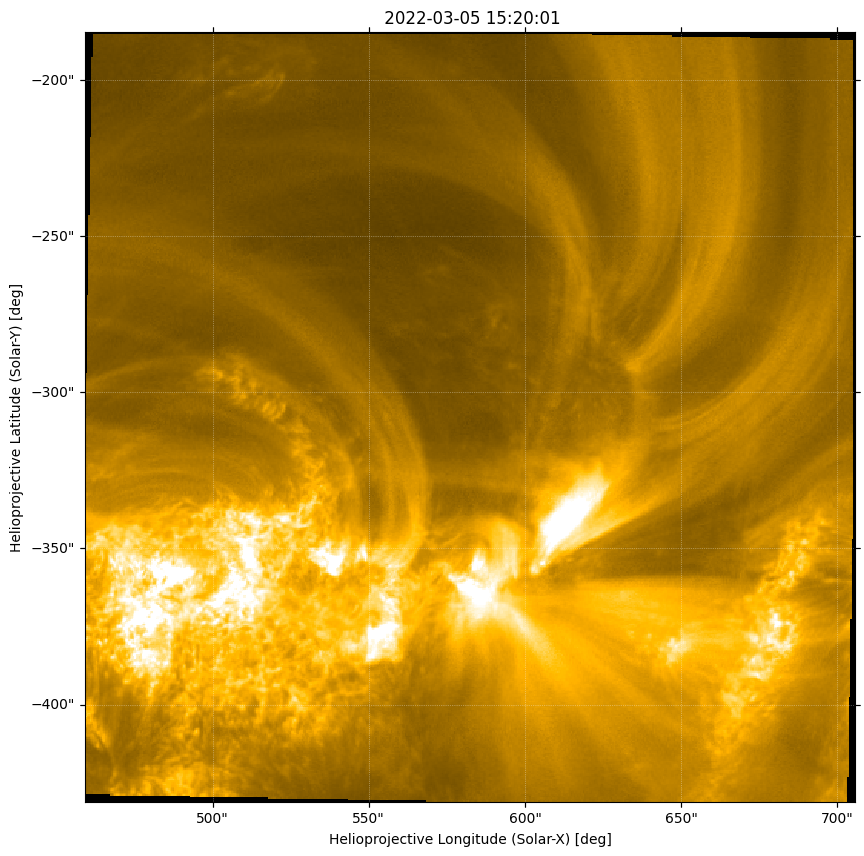

In [19]:
ani = eui_stable_seq.plot()

ani.save('gifs/stable_eui_animation.gif')

![SegmentLocal](gifs/shifted_eui_animation.gif "segment")


Great! Now the EUI pointing is relatively consistent with itself!



---

The WCS keywords in these FITS files give lots of useful information on these observations. 

A list of keywords can be found here: https://www.sidc.be/EUI/data/documents/SP-ROB-SOEUI-19001-DPDD_1.8.pdf

Keywords built in to SunPy can be accessed like this: `map.KEYWORD` where the list of supported keywords can be found here: https://docs.sunpy.org/en/stable/generated/api/sunpy.map.sources.EUIMap.html#sunpy.map.sources.EUIMap

If the keywords isn't nicely built into the EUI Sunpy map, they can accessed like so: `map.meta['KEYWORD']`


Let's try it out! Say we want to know the distance between Solar Orbiter/EUI and the Sun. This is built in to the SunPy map:

In [20]:
eui_seq[0].dsun

<Distance 7.7597452e+10 m>

If we want to know this value in terms of AU, we can do the conversion or simply use astropy!

In [21]:
eui_seq[0].dsun.to(u.AU)

<Distance 0.51870693 AU>

Another useful parameter is the angle from the Earth-Sun line... This isn't built into the SunPy map but ...

In [22]:
eui_seq[0].meta['HGLT_OBS'] * u.deg # s/c Heliographic latitude (B0 angle) 

<Quantity -4.24661104 deg>

time delay

In [23]:
time_delay = (eui_seq[0].meta['EAR_TDEL'] * u.s).to(u.min)
time_delay

<Quantity 3.93509727 min>

There's an almost 4 minute time delay between when ... We'll need to take this into account when aligning with ...

---

Now let's bring in AIA data! Before downloading, we have to consider the fact that EUI is at a different distance from the Sun than SDO. We have to consider this timing offset when querying for AIA data

In [24]:
### calculate timing offset ####

start_time_aia = astropy.time.Time(start_time, format='iso') + time_delay
end_time_aia = astropy.time.Time(end_time, format='iso') + time_delay

Now we have everything in terms of a 1 AU detection time -- we'll use these times to query for AIA data. For comparison purposes, we'll retrieve 171 Å data since it's a similar channel as HRIEUV's 174 Å channel

In [25]:
# AIA

# include new timing
time = a.Time(start_time_aia, end_time_aia)

instrument = a.Instrument('AIA')
wavelength = a.Wavelength(171*u.angstrom)  # 171 angstrom filter

aia_result = Fido.search(instrument & time & wavelength)
print(aia_result)

Results from 1 Provider:

3 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Total estimated size: 203.366 Mbyte

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2022-03-05 15:23:57.000 2022-03-05 15:23:58.000    SDO ...    FULLDISK 64.64844
2022-03-05 15:24:09.000 2022-03-05 15:24:10.000    SDO ...    FULLDISK 64.64844
2022-03-05 15:24:21.000 2022-03-05 15:24:22.000    SDO ...    FULLDISK 64.64844




In [26]:
# fetch the data files
aia_files = Fido.fetch(aia_result)

# read the data files in as a sequence of SunPy maps
aia_seq = sunpy.map.Map(aia_files, sequence=True)

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

Now we have our AIA data as SunPy maps!

2025-02-20 11:59:36 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 11:59:36 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


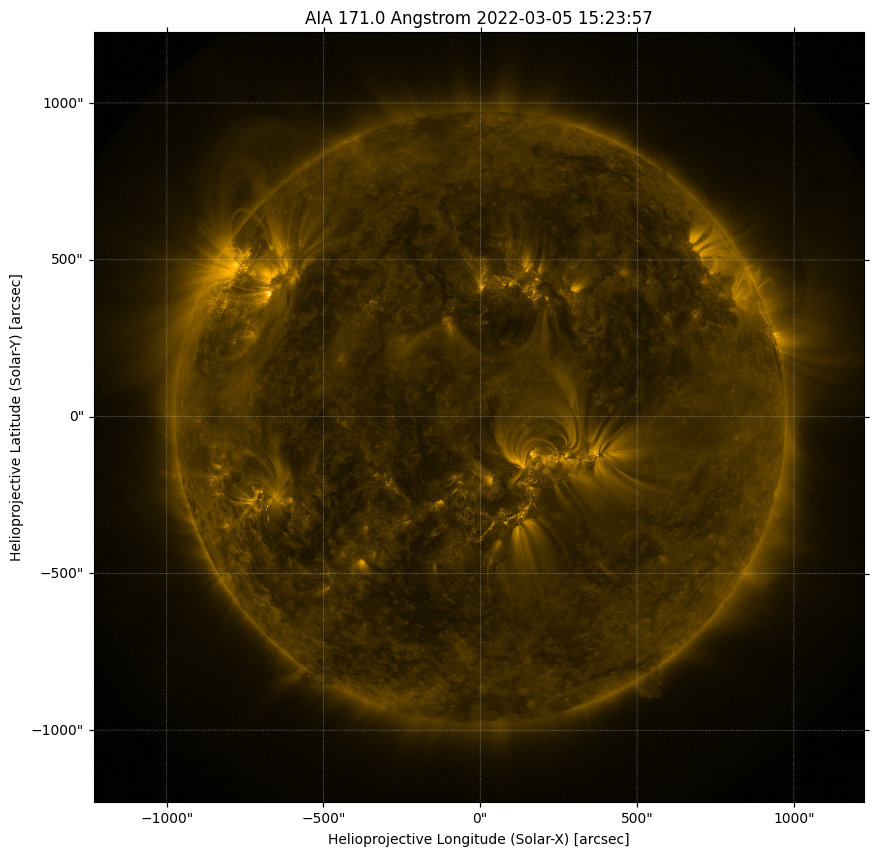

In [27]:
for each_map in aia_seq:

    # normalize each map the same way
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7000, stretch=SqrtStretch())
    
plt.figure()
ani = aia_seq.plot()

# will save a gif 
ani.save('gifs/first_aia_animation.gif')

![SegmentLocal](gifs/first_aia_animation.gif "segment")

... the temporal cadence of AIA is 10s ... EUI 5s ... match with eui maps closest in time

In [28]:
matched_aia_maps = []

for one_map in eui_seq:

    eui_map = one_map # map with time to match

    wanted_time = astropy.time.Time(eui_map.date, format='iso')

    # don't forget about the time delay!
    times = [abs(astropy.time.Time(aia_map.date, format='iso') - time_delay - wanted_time) for aia_map in aia_seq]

    # index of map that is closest in time
    closest_i = np.argmin(times)

    match_aia = aia_seq[closest_i]

    matched_aia_maps.append(match_aia)

matched_aia_seq = sunpy.map.Map(matched_aia_maps, sequence=True)

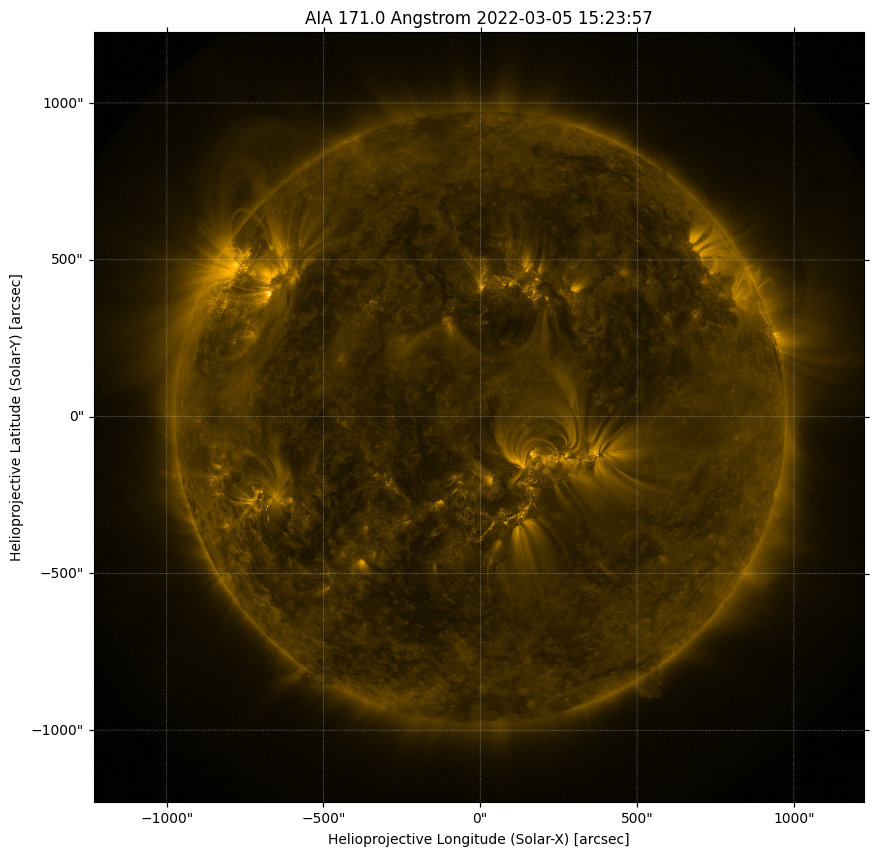

In [29]:
ani = matched_aia_seq.plot()

In order to align our AIA 171 Å data with our EUI 174 Å data, we'll use SunPy's reproject function:

In [30]:
aia_reprojected_maps = []

for one_map in matched_aia_seq:
    
    reprojected_map = one_map.reproject_to(eui_rotated_seq[0].wcs) # all reprojected to the first eui image

    reprojected_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3000, stretch=SqrtStretch())

    aia_reprojected_maps.append(reprojected_map)

aia_reprojected_seq = sunpy.map.Map(aia_reprojected_maps, sequence=True)

2025-02-20 11:59:45 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 11:59:45 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: AIA 171.0 Angstrom 2022-03-05 15:23:57.rsun_meters=696000000.0 m;  2022-03-05 15:20:01.rsun_meters=695700000.0 m. This might cause unexpected results during reprojection.
2025-02-20 11:59:45 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 11:59:45 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 11:59:45 - sunpy - WARNING: SunpyUserWarning: rsun mismatch detected: AIA 171.0 Angstrom 2022-03-05 15:24:09.rsun_meters=696000000.0 m;  2022-03-05 15:20:01.rsun_meters=695700000.0 m. This might cause unexpected results during reprojection.
2025-02-20 11:59:45 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 11:59:46 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 11:59:46 - sunpy - WARNING: SunpyUserWarning:

2025-02-20 11:59:46 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 11:59:46 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


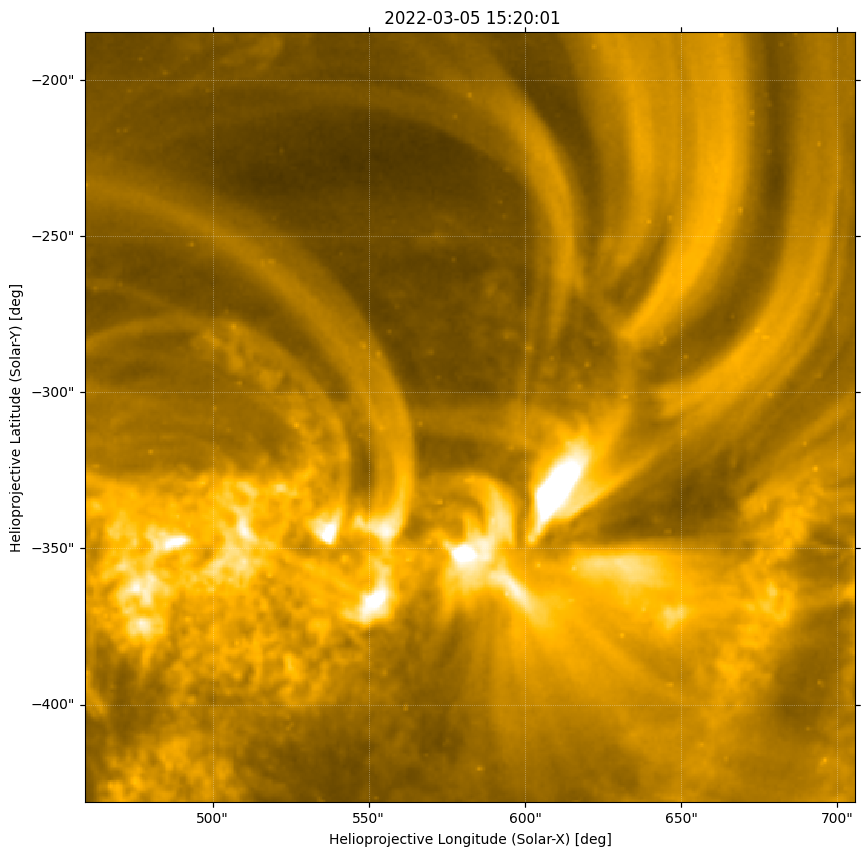

In [31]:
plt.figure()
ani = aia_reprojected_seq.plot()

# will save a gif 
ani.save('gifs/reprojected_aia_animation.gif')

![SegmentLocal](gifs/reprojected_aia_animation.gif "segment")

Let's plot EUI and AIA side by side.

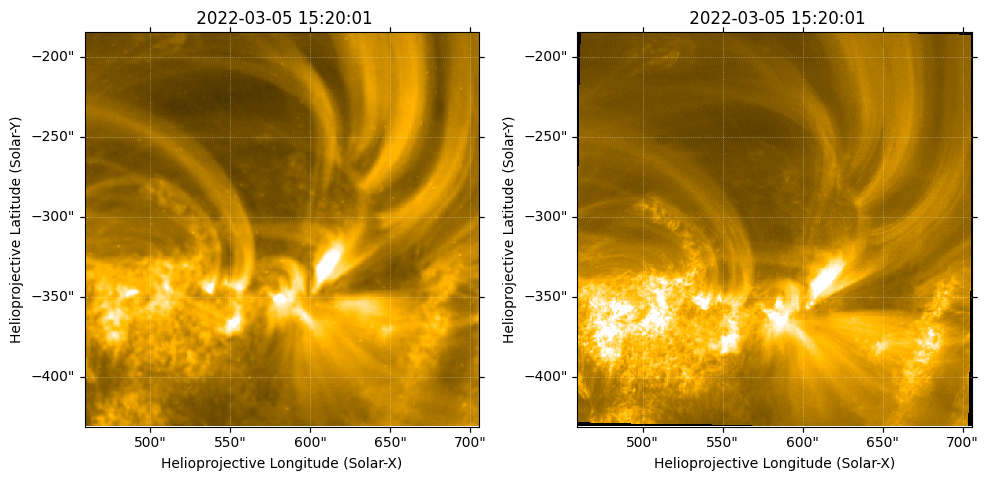

In [32]:
i = 0

aia_map = aia_reprojected_seq[i]
eui_map = eui_stable_seq[i]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121, projection=aia_map)
aia_map.plot(axes=ax)

ax = fig.add_subplot(122, projection=eui_map)
eui_map.plot(axes=ax)

plt.tight_layout()
plt.show()

We used SunPy routines to align EUI and AIA, but in plotting them side-by-side, we see that they are not well-aligned We used the fits file header information to align them like this, so we'll need to rely on an alternate technique -- cross-correlation again. But now instead of cross-correlating consecutive images in a time series (like we did for the EUI observation), now we'll cross-correlate each EUI 174 image with the AIA 171 image that is closest in time (EUI has a faster cadence so it won't be one to one).

In this case, the features should line up pretty well (the AIA 171 and EUI 174 passbands are similar), so we'll cross-correlate the FOV shown above.

In [33]:
shifts = []

for i in range(len(eui_stable_seq)): # on the derotated aia sequence!
    
    aia_map = aia_reprojected_maps[i]
    eui_map = eui_stable_seq[i]

    img1 = aia_map.data # reference image
    img2 = eui_map.data # image to move
    
    # sub pixel cross correlation
    shift, error, phasediff = skimage.registration.phase_cross_correlation(img1, # reference image
                                                                           img2, # moving image
                                                                           upsample_factor=100)
    shifts.append(shift)

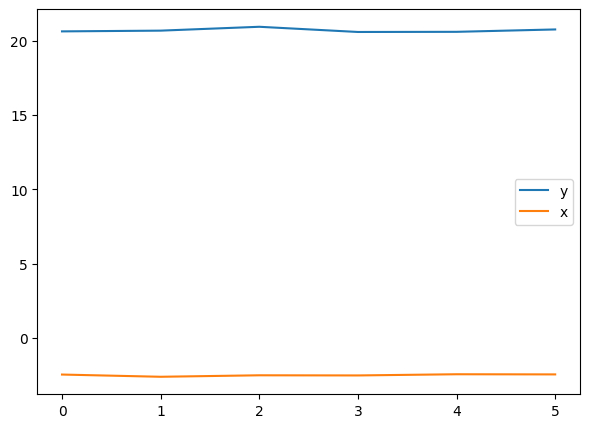

In [34]:
plt.figure(figsize=(7, 5))

plt.plot(shifts, label=['y','x'])
plt.legend()

We see that it's a roughly constant offset in x and y. We will shift each EUI map by...

In [35]:
x_mean, y_mean = np.mean(shifts, axis=0)

# Create a new array filled with [x_mean, y_mean]
mean_shifts = np.full_like(shifts, [x_mean, y_mean])

print(mean_shifts)

[[20.71       -2.50833333]
 [20.71       -2.50833333]
 [20.71       -2.50833333]
 [20.71       -2.50833333]
 [20.71       -2.50833333]
 [20.71       -2.50833333]]


In [36]:
shifted_maps = []

for i, one_map in enumerate(eui_stable_seq): # apply to eui sequence

    shift = mean_shifts[i]

    shifted_map = apply_shift(one_map, 
                              shift, 
                              cmap='solar orbiterhri_euv174', 
                              norm=ImageNormalize(vmin=0, vmax=10000, stretch=SqrtStretch()))
    
    shifted_maps.append(shifted_map)

eui_shifted_seq = sunpy.map.Map(shifted_maps, sequence=True)

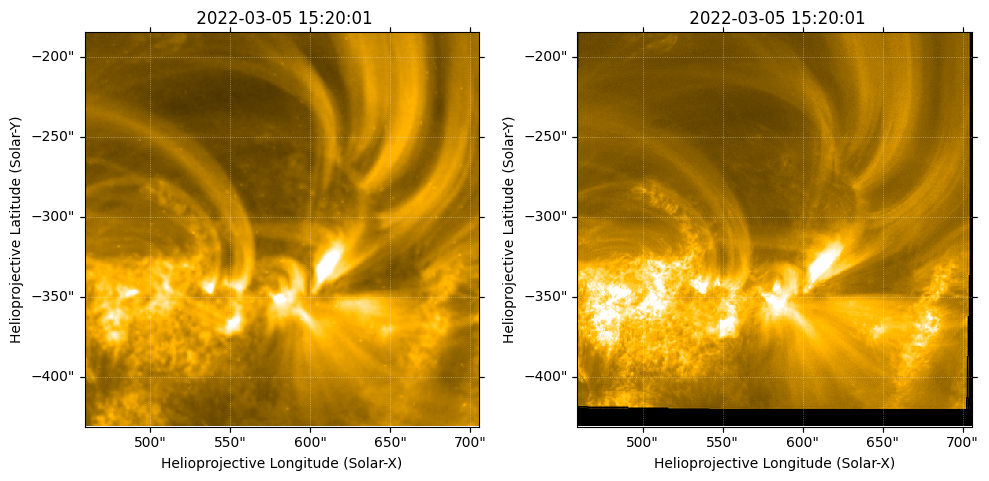

In [37]:
i = 0

aia_map = aia_reprojected_maps[i]
eui_map = eui_shifted_seq[i]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121, projection=aia_map)
aia_map.plot(axes=ax)

ax = fig.add_subplot(122, projection=eui_map)
eui_map.plot(axes=ax)

plt.tight_layout()
plt.show()

Now the alignment is even better! Let's make a movie!

  0%|                                                                  | 0/6 [00:00<?, ?it/s]

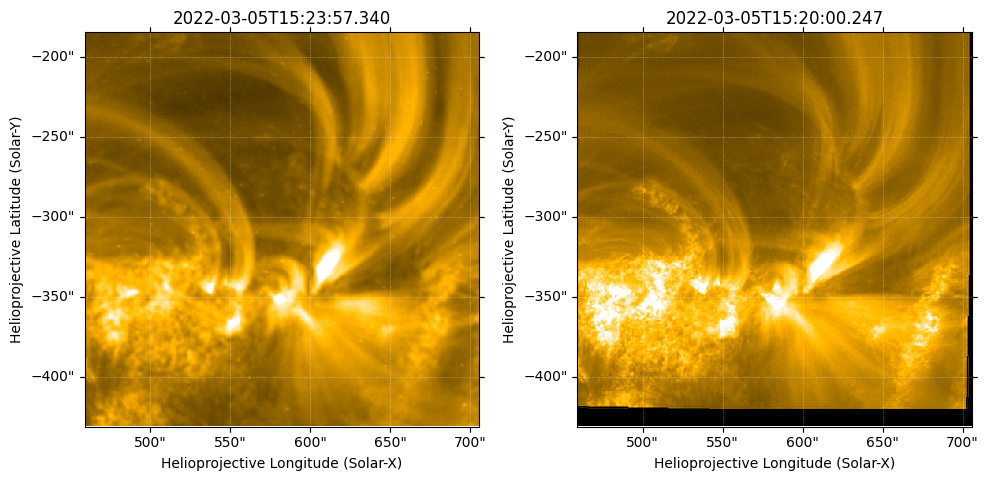

 17%|█████████▋                                                | 1/6 [00:00<00:03,  1.65it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|███████████████████▎                                      | 2/6 [00:00<00:01,  2.50it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|█████████████████████████████                             | 3/6 [00:01<00:01,  2.99it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|██████████████████████████████████████▋                   | 4/6 [00:01<00:00,  3.29it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|████████████████████████████████████████████████▎         | 5/6 [00:01<00:00,  3.46it/s]

<Figure size 1000x1000 with 0 Axes>

100%|██████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.16it/s]


In [38]:
fig = plt.figure(figsize=(10, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/aia_and_eui.gif", dpi=200):
    
    for i in tqdm(range(len(aia_reprojected_maps))):

        aia_map = aia_reprojected_maps[i]
        ax1 = fig.add_subplot(121, projection=aia_map.wcs)
        aia_map.plot(axes=ax1, title=matched_aia_seq[i].date)

        eui_map = eui_shifted_seq[i]
        ax2 = fig.add_subplot(122, projection=eui_map.wcs)
        eui_map.plot(axes=ax2, title=eui_seq[i].date)

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # runs the frame for 0.01 seconds
        writer.grab_frame()  # this saves the frame

        ax1.clear(); ax2.clear()

![SegmentLocal](gifs/aia_and_eui.gif "segment")

---

Woohoo! We have AIA and EUI well aligned! But what if we wanted to throw IRIS data into the mix... we can retrieve IRIS data the same way we did for EUI and AIA.

In [39]:
### pull iris data

# include new timing
time = a.Time(start_time_aia, end_time_aia)

instrument = a.Instrument('IRIS')
wavelength = a.Wavelength(1400*u.angstrom)

# Perform the search
iris_result = Fido.search(instrument & time & wavelength)

print(iris_result)

Results from 1 Provider:

2 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Total estimated size: 554.697 Mbyte

       Start Time               End Time        Source ... Extent Type  Size 
                                                       ...             Mibyte
----------------------- ----------------------- ------ ... ----------- ------
2022-03-05 15:09:30.000 2022-03-05 16:09:29.000   IRIS ... PARTIAL_SUN  445.0
2022-03-05 15:09:30.000 2022-03-05 16:09:20.000   IRIS ... PARTIAL_SUN   84.0




In [40]:
iris_result['vso']

<sunpy.net.vso.table_response.VSOQueryResponseTable object at 0x15c0bb5e0>
       Start Time               End Time        Source ... Extent Type  Size 
                                                       ...             Mibyte
----------------------- ----------------------- ------ ... ----------- ------
2022-03-05 15:09:30.000 2022-03-05 16:09:29.000   IRIS ... PARTIAL_SUN  445.0
2022-03-05 15:09:30.000 2022-03-05 16:09:20.000   IRIS ... PARTIAL_SUN   84.0

In [41]:
iris_files = Fido.fetch(iris_result)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

In [42]:
iris_files

['/Users/aylaweitz/sunpy/data/iris_l2_20220305_150930_3600607418_raster.tar.gz', '/Users/aylaweitz/sunpy/data/iris_l2_20220305_150930_3600607418_SJI_1400_t000.fits.gz']

In [43]:
sji_file = '/Users/aylaweitz/sunpy/data/iris_l2_20220305_150930_3600607418_SJI_1400_t000.fits.gz'

In [44]:
def get_iris_data(filename):
    """Read in IRIS data from local file and
    create array of SunPy maps

    Parameters
    ----------
    filename: str
        filename of IRIS data to read in

    Returns
    -------
    iris_map_array: np.array
        IRIS observations as array of SunPy maps
    """
    hdul = fits.open(filename)
    
    # get header info
    header = hdul[0].header
    
    aux = hdul[1].data # auxillary metadata
    aux_hd = hdul[1].header
    
    # get timing of observation -- https://iris.lmsal.com/itn45/IRIS-LMSALpy_chapter6.html?highlight=timing#time-of-observations-and-exposure-times
    time_diff = aux[:, aux_hd['TIME']]
    times = np.datetime64(header['DATE_OBS']) + time_diff * np.timedelta64(1, 's')
    
    # LOOP THROUGH AND CREATE SunPy maps for each
    iris_map_array = []

    for i in tqdm(range(len(hdul[0].data))):

        one_data = hdul[0].data[i]
        
        # change 'DATE_OBS' value in header since that it what SunPy will read as the time
        time = times[i]
        header['DATE_OBS'] = str(time)

        iris_map = sunpy.map.Map(one_data, header)
        iris_map_array.append(iris_map)


    return iris_map_array

In [45]:
# read in the data files
iris_maps = get_iris_data(sji_file)

# read the data files in as a sequence of SunPy maps
iris_seq = sunpy.map.Map(iris_maps, sequence=True)

100%|████████████████████████████████████████████████████| 352/352 [00:00<00:00, 1003.15it/s]


In [46]:
matched_iris_maps = []

for one_map in eui_seq:

    eui_map = one_map # map with time to match

    wanted_time = astropy.time.Time(eui_map.date, format='iso')

    # don't forget about the time delay!
    times = [abs(astropy.time.Time(iris_map.date, format='iso') - time_delay - wanted_time) for iris_map in iris_seq]

    # index of map that is closest in time
    closest_i = np.argmin(times)

    match_iris = iris_seq[closest_i]

    matched_iris_maps.append(match_iris)

matched_iris_seq = sunpy.map.Map(matched_iris_maps, sequence=True)

2025-02-20 12:00:05 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
2025-02-20 12:00:05 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

2025-02-20 12:00:05 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 12:00:05 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-20 12:00:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
2025-02-20 12:00:06 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs

2025-02-20 12:00:06 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]
2025-02-20 12:00:06 - sunpy - WARNING: SunpyMetadataWarning:

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


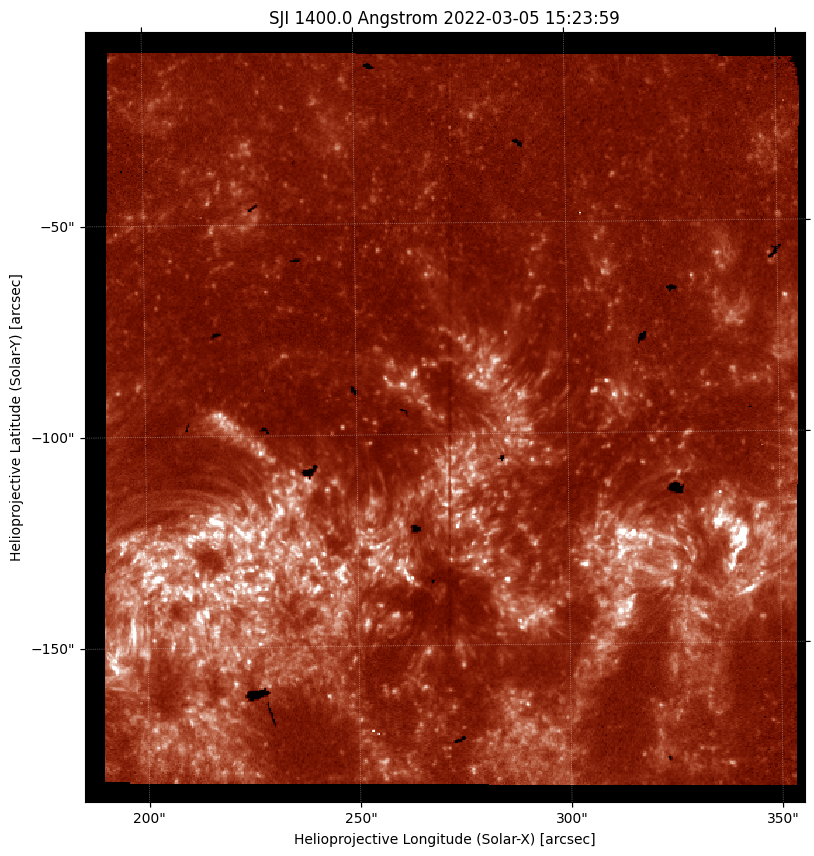

In [47]:
for each_map in matched_iris_seq:

    # normalize each map the same way
    each_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=70, stretch=SqrtStretch())
    
plt.figure()
ani = matched_iris_seq.plot()

# will save a gif 
ani.save('gifs/first_iris_animation.gif')

In [48]:
iris_reprojected_maps = []

for one_map in matched_iris_seq:
    
    reprojected_map = one_map.reproject_to(eui_rotated_seq[0].wcs) # all reprojected to the first eui image

    # reprojected_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7000, stretch=SqrtStretch())

    iris_reprojected_maps.append(reprojected_map)

iris_reprojected_seq = sunpy.map.Map(iris_reprojected_maps, sequence=True)

2025-02-20 12:00:07 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 12:00:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-02-20 12:00:07 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 12:00:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-02-20 12:00:07 - reproject.common - INFO: Calling _reproject_full in non-dask mode


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-20 12:00:07 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-02-20 12:00:07 - reproject.common - INFO: Calling _reproject_full in non-dask mode


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-20 12:00:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-02-20 12:00:08 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-02-20 12:00:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-02-20 12:00:08 - reproject.common - INFO: Calling _reproject_full in non-dask mode


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-20 12:00:08 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


2025-02-20 12:00:08 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2025-02-20 12:00:08 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


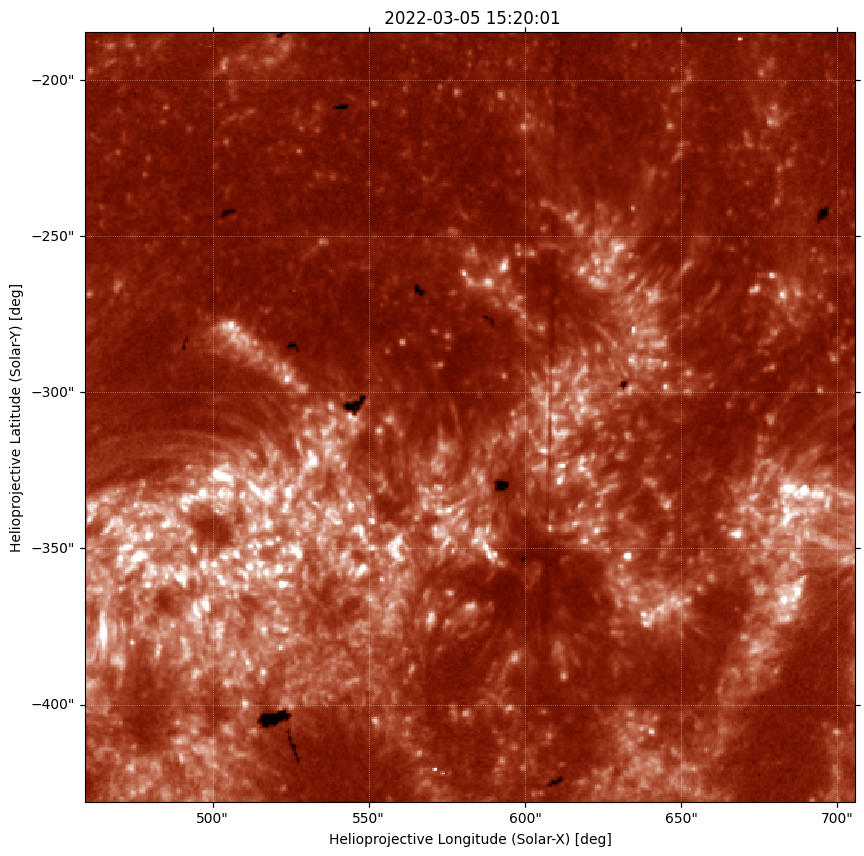

In [49]:
plt.figure()
ani = iris_reprojected_seq.plot()

# will save a gif 
ani.save('gifs/aligned_iris_animation.gif')

  0%|                                                                  | 0/6 [00:00<?, ?it/s]

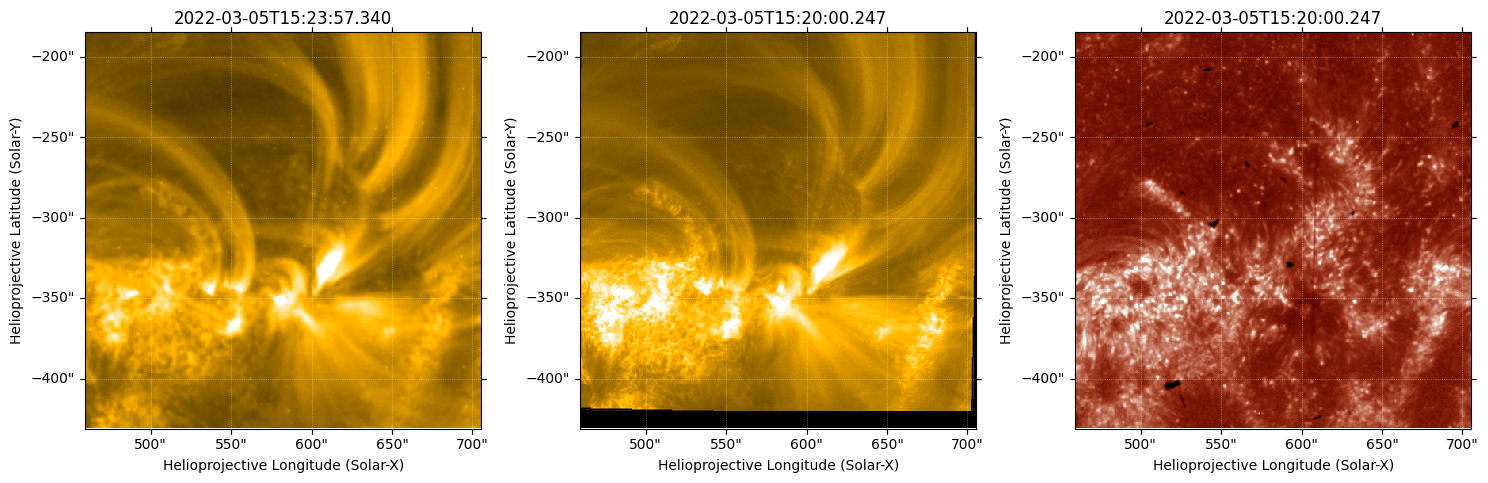

 17%|█████████▋                                                | 1/6 [00:00<00:04,  1.14it/s]

<Figure size 1000x1000 with 0 Axes>

 33%|███████████████████▎                                      | 2/6 [00:01<00:02,  1.67it/s]

<Figure size 1000x1000 with 0 Axes>

 50%|█████████████████████████████                             | 3/6 [00:01<00:01,  1.98it/s]

<Figure size 1000x1000 with 0 Axes>

 67%|██████████████████████████████████████▋                   | 4/6 [00:02<00:01,  1.86it/s]

<Figure size 1000x1000 with 0 Axes>

 83%|████████████████████████████████████████████████▎         | 5/6 [00:02<00:00,  1.83it/s]

<Figure size 1000x1000 with 0 Axes>

100%|██████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.85it/s]


In [50]:
fig = plt.figure(figsize=(15, 5))

writer = PillowWriter(fps=5)
with writer.saving(fig, "gifs/aia_and_eui_and_iris.gif", dpi=200):
    
    for i in tqdm(range(len(aia_reprojected_maps))):

        aia_map = aia_reprojected_maps[i]
        ax1 = fig.add_subplot(131, projection=aia_map.wcs)
        aia_map.plot(axes=ax1, title=matched_aia_seq[i].date)

        eui_map = eui_shifted_seq[i]
        ax2 = fig.add_subplot(132, projection=eui_map.wcs)
        eui_map.plot(axes=ax2, title=eui_seq[i].date)

        iris_map = iris_reprojected_seq[i]
        ax3 = fig.add_subplot(133, projection=iris_map.wcs)
        iris_map.plot(axes=ax3, title=eui_seq[i].date)

        plt.tight_layout()

        plt.draw()
        plt.pause(0.01)  # runs the frame for 0.01 seconds
        writer.grab_frame()  # this saves the frame

        ax1.clear(); ax2.clear(); ax3.clear()

![SegmentLocal](gifs/aia_and_eui_and_iris.gif "segment")

Now we have well-aligned data among 3 instruments!